In [3]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [ ]:
import numpy as np
def loss_f(ground_truth_cells, small_model_cells, groundtruth_maskfiles, small_maskfiles, cell_sizes, small_error_history, i, cell_index):
        ground_truth_cells_copy = ground_truth_cells.copy()
        small_model_cells_copy = small_model_cells.copy()
        cell_sizes_copy = cell_sizes.copy()

        j = 0

        while len(ground_truth_cells_copy) != 0:
            
            if len(small_model_cells) == 0:
                ground_truth_cells_copy.pop(0)
                cell_sizes_copy.pop(0)
                small_error_history[i] += 1./(cell_index)
                #small_error_history[i] += 1.
                continue

            if j >= (len(small_model_cells_copy)):
                    small_error_history[i] += 1./(cell_index)
                    #small_error_history[i] += 1.
                    ground_truth_cells_copy.pop(0)
                    cell_sizes_copy.pop(0)
                    j = 0
                    small_model_cells_copy = small_model_cells.copy()
                    break
            if (ground_truth_cells_copy[0][0] - small_model_cells_copy[j][0])**2 + (ground_truth_cells_copy[0][1] - small_model_cells_copy[j][1])**2 <= cell_sizes_copy[0]/4:
                cell_pixel = groundtruth_maskfiles[i][int(ground_truth_cells_copy[0][0])][int(ground_truth_cells_copy[0][1])]
                matched_p = 0
                unmatched_p = 0
                gt_list = np.where(groundtruth_maskfiles[i] == cell_pixel)
                gt_list = [(gt_list[0][i], gt_list[1][i]) for i in range(len(gt_list[0]))]
                benchmark_list = np.where(small_maskfiles[i] == cell_pixel)
                benchmark_list = [(benchmark_list[0][i], benchmark_list[1][i]) for i in range(len(benchmark_list[0]))]
                matched_p = len(set(gt_list).intersection(set(benchmark_list)))
                unmatched_p = len(gt_list) + len(benchmark_list) - 2*matched_p
                print(str(matched_p) + "matched")
                print(str(unmatched_p) + "unmatched_p")
                if (matched_p+unmatched_p) == 0:
                    small_error_history[i] += 1./(cell_index)
                    #small_error_history[i] += 1.
                else:
                    small_error_history[i] += (1./(cell_index))*(unmatched_p/(unmatched_p + matched_p))
                    #small_error_history[i] += unmatched_p/(unmatched_p + matched_p)
                ground_truth_cells_copy.pop(0)
                cell_sizes_copy.pop(0)
                small_model_cells.pop(j)
                small_model_cells_copy = small_model_cells.copy()
                j = 0
            else:
                small_model_cells_copy.pop(j)
                j += 1
        return small_error_history

In [ ]:
def get_cells(large_maskfiles, large_model_cells, i):
    cell_sizes = []
    cell_index = 1
    while True:
            one_cell = np.where(np.array(large_maskfiles[i]) == cell_index)
            
            if len(one_cell) == 2:
                if len(one_cell[0]) == 0:
                    break
                x = np.average(one_cell[0])
                y = np.average(one_cell[1])
                large_model_cells.append([x,y])
                cell_sizes.append(len(one_cell[0]))
                cell_index += 1
            else:
                break
    return large_model_cells, cell_sizes, cell_index

In [ ]:
import numpy as np
from pathlib import Path
import os
from cellpose import io
import math
import matplotlib.pyplot as plt

average = 5
large_error_history = np.zeros(1597)
mixed_error_history = np.zeros(1597)
small_error_history = np.zeros(1597)

for iteration in range(1, 1 + average):
    benchmark_maskdir = "/home/ameyasu/cuda_ws/src/full_curve_test/{}/large/masks".format(iteration)
    benchmark_maskfiles = io.get_image_files(benchmark_maskdir)
    large_maskfiles = [io.imread(f) for f in benchmark_maskfiles]

    benchmark_maskdir = "/home/ameyasu/cuda_ws/src/full_curve_test/{}/small/masks".format(iteration)
    benchmark_maskfiles = io.get_image_files(benchmark_maskdir)
    small_maskfiles = [io.imread(f) for f in benchmark_maskfiles]

    benchmark_maskdir = "/home/ameyasu/cuda_ws/src/full_curve_test/{}/mixed/masks".format(iteration)
    benchmark_maskfiles = io.get_image_files(benchmark_maskdir)
    mixed_maskfiles = [io.imread(f) for f in benchmark_maskfiles]


    groundtruth_maskdir = "/home/ameyasu/cuda_ws/src/full_curve_test/{}/groundtruth/masks".format(iteration)
    groundtruth_maskfiles = io.get_image_files(groundtruth_maskdir)
    groundtruth_maskfiles = [io.imread(f) for f in groundtruth_maskfiles]


    if len(groundtruth_maskfiles) != len(benchmark_maskfiles):
        print("not compatible dimensions")

    for i in range(0, len(groundtruth_maskfiles)):
    #for i in range(0, 10):
        error = 0.
        norm_g = 0.
        norm_b = 0.
        ground_truth_cells = []
        large_model_cells = []
        small_model_cells = []
        mixed_model_cells = []
        average_cell_size = 0
        print(i)
        
        
        small_model_cells, cell_sizes, cell_index = get_cells(small_maskfiles, small_model_cells, i)
        large_model_cells, cell_sizes, cell_index = get_cells(large_maskfiles, large_model_cells, i)
        mixed_model_cells, cell_sizes, cell_index = get_cells(mixed_maskfiles, mixed_model_cells, i)
        ground_truth_cells, cell_sizes, cell_index = get_cells(large_maskfiles, ground_truth_cells, i)
        
        mixed_error_history = loss_f(ground_truth_cells, mixed_model_cells, groundtruth_maskfiles, mixed_maskfiles, cell_sizes, mixed_error_history, i, cell_index)
        small_error_history = loss_f(ground_truth_cells, small_model_cells, groundtruth_maskfiles, small_maskfiles, cell_sizes, small_error_history, i, cell_index)
        large_error_history = loss_f(ground_truth_cells, large_model_cells, groundtruth_maskfiles, large_maskfiles, cell_sizes, large_error_history, i, cell_index)

large_error_history /= average
small_error_history /= average
mixed_error_history /= average
    
smooth_window = np.ones(100)*0.01

smoothed_large_error_history = np.zeros(len(large_error_history)-len(smooth_window))
for i in range(len(large_error_history)-len(smooth_window)):
    temp_list = [smooth_window[j]*large_error_history[j+i] for j in range(len(smooth_window))]
    smoothed_large_error_history[i] = np.sum(temp_list)

smoothed_small_error_history = np.zeros(len(small_error_history)-len(smooth_window))
for i in range(len(small_error_history)-len(smooth_window)):
    temp_list = [smooth_window[j]*small_error_history[j+i] for j in range(len(smooth_window))]
    smoothed_small_error_history[i] = np.sum(temp_list)

smoothed_mixed_error_history = np.zeros(len(mixed_error_history)-len(smooth_window))
for i in range(len(mixed_error_history)-len(smooth_window)):
    temp_list = [smooth_window[j]*mixed_error_history[j+i] for j in range(len(smooth_window))]
    smoothed_mixed_error_history[i] = np.sum(temp_list)


plt.plot(np.array(range(1,len(smoothed_large_error_history)+1)), smoothed_large_error_history, label='large')
plt.plot(np.array(range(1,len(smoothed_small_error_history)+1)), smoothed_small_error_history, label='small')
plt.plot(np.array(range(1,len(smoothed_mixed_error_history)+1)), smoothed_mixed_error_history, label='mixed')


plt.legend()
plt.xlabel("Time Frame")
plt.ylabel("Rate of Segmentation Error")
plt.savefig('average_mixed_small_large.png')
plt.show()

In [ ]:
import numpy as np
from pathlib import Path
import os
from cellpose import io
import math
import matplotlib.pyplot as plt

benchmark_maskdir = "/home/ameyasu/cuda_ws/src/full_curve_test/large/masks"
benchmark_maskfiles = io.get_image_files(benchmark_maskdir)
benchmark_maskfiles = [io.imread(f) for f in benchmark_maskfiles]

groundtruth_maskdir = "/home/ameyasu/cuda_ws/src/full_curve_test/groundtruth/masks"
groundtruth_maskfiles = io.get_image_files(groundtruth_maskdir)
groundtruth_maskfiles = [io.imread(f) for f in groundtruth_maskfiles]


if len(groundtruth_maskfiles) != len(benchmark_maskfiles):
    print("not compatible dimensions")

error_history = []


#cross correlation loss

for index in range(0, len(groundtruth_maskfiles)):
    error = 0.
    norm_g = 0.
    norm_b = 0.
    for i, row in enumerate(groundtruth_maskfiles[index]):
        for j, pixel in enumerate(row):
                error += (benchmark_maskfiles[index][i][j]*pixel)**2
                norm_g += pixel**2
                norm_b += benchmark_maskfiles[index][i][j]**2
    
    error_history.append(error/math.sqrt(norm_g*norm_b))

error_history = savitzky_golay(error_history, 21, 4)
plt.plot(np.array(range(1,len(groundtruth_maskfiles)+1)), error_history, label='large')


benchmark_maskdir = "/home/ameyasu/cuda_ws/src/full_curve_test/small/masks"
benchmark_maskfiles = io.get_image_files(benchmark_maskdir)
benchmark_maskfiles = [io.imread(f) for f in benchmark_maskfiles]

if len(groundtruth_maskfiles) != len(benchmark_maskfiles):
    print("not compatible dimensions")

error_history = []


#cross correlation loss

for index in range(0, len(groundtruth_maskfiles)):
    error = 0.
    norm_g = 0.
    norm_b = 0.
    for i, row in enumerate(groundtruth_maskfiles[index]):
        for j, pixel in enumerate(row):
                error += (benchmark_maskfiles[index][i][j]*pixel)**2
                norm_g += pixel**2
                norm_b += benchmark_maskfiles[index][i][j]**2
    
    error_history.append(error/math.sqrt(norm_g*norm_b))

error_history = savitzky_golay(error_history, 21, 4)
plt.plot(np.array(range(1,len(groundtruth_maskfiles) + 1)), error_history, label='small')
'''

benchmark_maskdir = "/home/ameyasu/cuda_ws/src/full_curve_test/mixed/masks"
benchmark_maskfiles = io.get_image_files(benchmark_maskdir)
benchmark_maskfiles = [io.imread(f) for f in benchmark_maskfiles]

if len(groundtruth_maskfiles) != len(benchmark_maskfiles):
    print("not compatible dimensions")

error_history = []


#cross correlation loss

for index in range(0, len(groundtruth_maskfiles)):
    error = 0.
    norm_g = 0.
    norm_b = 0.
    for i, row in enumerate(groundtruth_maskfiles[index]):
        for j, pixel in enumerate(row):
                error += (benchmark_maskfiles[index][i][j]*pixel)**2
                norm_g += pixel**2
                norm_b += benchmark_maskfiles[index][i][j]**2
    
    error_history.append(error/math.sqrt(norm_g*norm_b))

error_history = savitzky_golay(error_history, 21, 4)
plt.plot(np.array(range(1,len(groundtruth_maskfiles) + 1)), error_history, label='mixed')

benchmark_maskdir = "/home/ameyasu/cuda_ws/src/full_curve_test/optimal_mixed/masks"
benchmark_maskfiles = io.get_image_files(benchmark_maskdir)
benchmark_maskfiles = [io.imread(f) for f in benchmark_maskfiles]

if len(groundtruth_maskfiles) != len(benchmark_maskfiles):
    print("not compatible dimensions")

error_history = []


#cross correlation loss

for index in range(0, len(groundtruth_maskfiles)):
    error = 0.
    norm_g = 0.
    norm_b = 0.
    for i, row in enumerate(groundtruth_maskfiles[index]):
        for j, pixel in enumerate(row):
                error += (benchmark_maskfiles[index][i][j]*pixel)**2
                norm_g += pixel**2
                norm_b += benchmark_maskfiles[index][i][j]**2
    
    error_history.append(error/math.sqrt(norm_g*norm_b))

error_history = savitzky_golay(error_history, 21, 4)
plt.plot(np.array(range(1,len(groundtruth_maskfiles) + 1)), error_history, label='optimal mixed')
'''
plt.legend()
plt.xlabel("Time Frame")
plt.ylabel("Cross Entropy Loss")
plt.show()


0
['/home/ameyasu/cuda_ws/src/full_curve_test/1/groundtruth/masks/real_01000_cp_masks_prediction.tif', '/home/ameyasu/cuda_ws/src/full_curve_test/1/groundtruth/masks/real_01001_cp_masks_prediction.tif', '/home/ameyasu/cuda_ws/src/full_curve_test/1/groundtruth/masks/real_01002_cp_masks_prediction.tif', '/home/ameyasu/cuda_ws/src/full_curve_test/1/groundtruth/masks/real_01003_cp_masks_prediction.tif', '/home/ameyasu/cuda_ws/src/full_curve_test/1/groundtruth/masks/real_01004_cp_masks_prediction.tif', '/home/ameyasu/cuda_ws/src/full_curve_test/1/groundtruth/masks/real_01005_cp_masks_prediction.tif', '/home/ameyasu/cuda_ws/src/full_curve_test/1/groundtruth/masks/real_01006_cp_masks_prediction.tif', '/home/ameyasu/cuda_ws/src/full_curve_test/1/groundtruth/masks/real_01007_cp_masks_prediction.tif', '/home/ameyasu/cuda_ws/src/full_curve_test/1/groundtruth/masks/real_01008_cp_masks_prediction.tif', '/home/ameyasu/cuda_ws/src/full_curve_test/1/groundtruth/masks/real_01009_cp_masks_prediction.tif

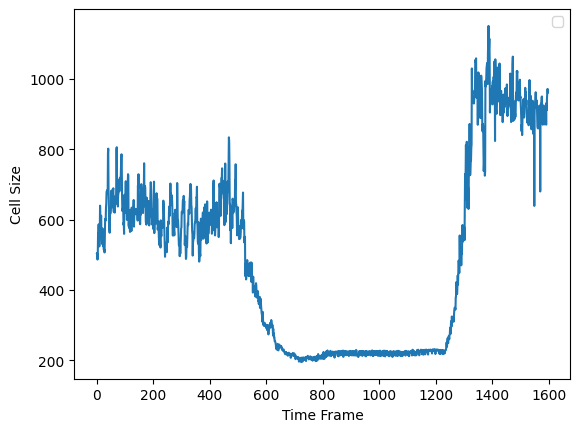

In [6]:
import numpy as np
from pathlib import Path
import os
from cellpose import io
import math
import matplotlib.pyplot as plt

cell_sizes = np.zeros(1597)

for i in range(0,5):
    groundtruth_maskdir = "/home/ameyasu/cuda_ws/src/full_curve_test/{}/groundtruth/masks".format(str(i+1))
    print(i)
    groundtruth_maskfiles = io.get_image_files(groundtruth_maskdir)
    groundtruth_maskfiles = [io.imread(f) for f in groundtruth_maskfiles]

    index = 0

    for image in groundtruth_maskfiles:
        cell_size = 0.
        cell_count = 1
        for i in image:
            for j in i:
                if j in range(1, 50):
                    cell_size += 1.
                    cell_count = j
        cell_sizes[index] += cell_size/cell_count
        index += 1

    #cell_sizes = savitzky_golay(cell_sizes, 21, 3)

cell_sizes = cell_sizes/5

plt.plot(np.array(range(1,len(groundtruth_maskfiles) + 1)), cell_sizes)

plt.legend()
plt.xlabel("Time Frame")
plt.ylabel("Cell Size")
plt.show()

2022-11-21 17:25:18,202 [WARNING] No handles with labels found to put in legend.


/tmp/ipykernel_58502/3256550251.py:53: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  window_size = np.abs(np.int(window_size))
/tmp/ipykernel_58502/3256550251.py:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in Nu

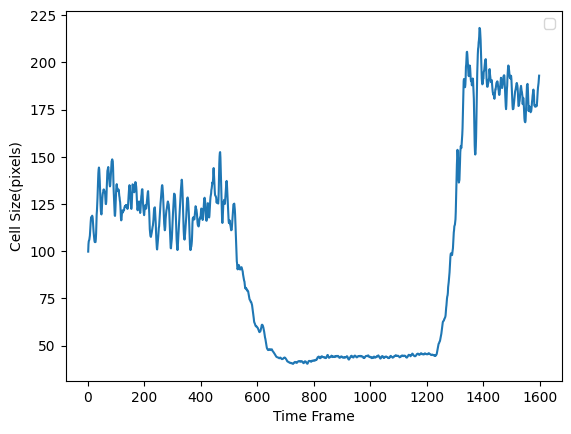

In [7]:
cell_sizes = np.array(cell_sizes)/5
cell_sizes = savitzky_golay(cell_sizes, 21, 4)
plt.plot(np.array(range(1,len(groundtruth_maskfiles) + 1)), cell_sizes)

plt.legend()
plt.xlabel("Time Frame")
plt.ylabel("Cell Size(pixels)")
plt.show()

In [ ]:
from cellpose import models
import numpy as np
import time, os, sys
from cellpose import models, core, utils
from cellpose import io, transforms
from pathlib import Path
import os
from cellpose import io
from omnipose.utils import normalize99
import matplotlib.pyplot as plt
# This checks to see if you have set up your GPU properly.
# CPU performance is a lot slower, but not a problem if 
# you are only processing a few images.
use_GPU = core.use_gpu()

model_ground_truth = models.CellposeModel(gpu=use_GPU, pretrained_model="/home/ameyasu/cuda_ws/src/benchmarking/cellpose_residual_on_style_on_concatenation_off_omni_omnipose_training_data_2022_10_07_00_50_12.177206_epoch_3999")


ground_truth_dir = "/home/ameyasu/cuda_ws/src/test/ground_truth"

chans = [0,0] #this means segment based on first channel, no second channel 

#ground truth first
files = io.get_image_files(ground_truth_dir)

imgs = [io.imread(f) for f in files]

# print some info about the images.
nimg = len(imgs)
print('number of images:',nimg)

fig = plt.figure(figsize=[40]*2) # initialize figure

for k in range(len(imgs)):
    img = transforms.move_min_dim(imgs[k]) # move the channel dimension last
    if len(img.shape)>2:
        # imgs[k] = img[:,:,1] # could pick out a specific channel
        imgs[k] = np.mean(img,axis=-1) # or just turn into grayscale 
        
    imgs[k] = normalize99(imgs[k])

n = [0] # make a list of integers to select which images you want to segment
n = range(nimg) # or just segment them all 

# define parameters
mask_threshold = -1 
verbose = 0 # turn on if you want to see more output 
use_gpu = use_GPU #defined above
transparency = True # transparency in flow output
rescale=None # give this a number if you need to upscale or downscale your images
omni = True # we can turn off Omnipose mask reconstruction, not advised 
flow_threshold = 0 # default is .4, but only needed if there are spurious masks to clean up; slows down output
resample = True #whether or not to run dynamics on rescaled grid or original grid 
cluster=True # use DBSCAN clustering

masks, flows, styles = model_ground_truth.eval([imgs[i] for i in n],channels=chans,rescale=rescale,mask_threshold=mask_threshold,transparency=transparency,
                                  flow_threshold=flow_threshold,omni=omni,cluster=cluster, resample=resample,verbose=verbose)

io.save_masks(imgs, masks, flows, files, 
              png=False,
              tif=True, # whether to use PNG or TIF format
              suffix='prediction', # suffix to add to files if needed 
              save_flows=False, # saves both RGB depiction as *_flows.png and the raw components as *_dP.tif
              save_outlines=False, # save outline images 
              dir_above=0, # save output in the image directory or in the directory above (at the level of the image directory)
              in_folders=True, # save output in folders (recommended)
              save_txt=False, # txt file for outlines in imageJ
              save_ncolor=False) # save ncolor version of masks for visualization and editing 


In [ ]:
from cellpose import models
import numpy as np
import time, os, sys
from cellpose import models, core, utils
from cellpose import io, transforms
from pathlib import Path
import os
from cellpose import io
from omnipose.utils import normalize99
import matplotlib.pyplot as plt
# This checks to see if you have set up your GPU properly.
# CPU performance is a lot slower, but not a problem if 
# you are only processing a few images.
use_GPU = core.use_gpu()
chans = [0,0]
#benchmarking second
#model_name = "/home/ameyasu/cuda_ws/src/7small_3large_new_omnipose/models/cellpose_residual_on_style_on_concatenation_off_omni_nclasses_4_7small_3large_new_omnipose_2022_11_01_20_32_35.126119_epoch_1501_loss_0.34"
#model_name = "/home/ameyasu/cuda_ws/src/mixed_data_small_set_omnipose/models/cellpose_residual_on_style_on_concatenation_off_omni_nclasses_4_mixed_data_small_set_omnipose_2022_11_02_17_47_18.202865_epoch_1501_loss_0.34"
#model_name = "/home/ameyasu/cuda_ws/src/large_data_small_set_omnipose/models/cellpose_residual_on_style_on_concatenation_off_omni_nclasses_4_large_data_small_set_omnipose_2022_11_02_02_55_56.868601_epoch_1501_loss_0.35"
model_name = "/home/ameyasu/cuda_ws/src/small_data_small_set_omnipose/models/cellpose_residual_on_style_on_concatenation_off_omni_nclasses_4_small_data_small_set_omnipose_2022_11_02_09_12_01.377555_epoch_1501_loss_0.37"
model_benchmark = models.CellposeModel(gpu=use_GPU, pretrained_model=model_name)
#benchmark_dir = "/home/ameyasu/cuda_ws/src/test/benchmark_optimal_mixed"
#benchmark_dir = "/home/ameyasu/cuda_ws/src/test/benchmark_mixed"
#benchmark_dir = "/home/ameyasu/cuda_ws/src/test/benchmark_large"
benchmark_dir = "/home/ameyasu/cuda_ws/src/test/benchmark_small"

files = io.get_image_files(benchmark_dir)

imgs = [io.imread(f) for f in files]

# print some info about the images.
nimg = len(imgs)
print('number of images:',nimg)

fig = plt.figure(figsize=[40]*2) # initialize figure

for k in range(len(imgs)):
    img = transforms.move_min_dim(imgs[k]) # move the channel dimension last
    if len(img.shape)>2:
        # imgs[k] = img[:,:,1] # could pick out a specific channel
        imgs[k] = np.mean(img,axis=-1) # or just turn into grayscale 
        
    imgs[k] = normalize99(imgs[k])

n = [0] # make a list of integers to select which images you want to segment
n = range(nimg) # or just segment them all 

# define parameters
mask_threshold = -1 
verbose = 0 # turn on if you want to see more output 
use_gpu = use_GPU #defined above
transparency = True # transparency in flow output
rescale=None # give this a number if you need to upscale or downscale your images
omni = True # we can turn off Omnipose mask reconstruction, not advised 
flow_threshold = 0 # default is .4, but only needed if there are spurious masks to clean up; slows down output
resample = True #whether or not to run dynamics on rescaled grid or original grid 
cluster=True # use DBSCAN clustering

masks, flows, styles = model_benchmark.eval([imgs[i] for i in n],channels=chans,rescale=rescale,mask_threshold=mask_threshold,transparency=transparency,
                                  flow_threshold=flow_threshold,omni=omni,cluster=cluster, resample=resample,verbose=verbose)

io.save_masks(imgs, masks, flows, files, 
              png=False,
              tif=True, # whether to use PNG or TIF format
              suffix='prediction', # suffix to add to files if needed 
              save_flows=False, # saves both RGB depiction as *_flows.png and the raw components as *_dP.tif
              save_outlines=False, # save outline images 
              dir_above=0, # save output in the image directory or in the directory above (at the level of the image directory)
              in_folders=True, # save output in folders (recommended)
              save_txt=False, # txt file for outlines in imageJ
              save_ncolor=False) # save ncolor version of masks for visualization and editing 